In [10]:
import os   # Importing necessary Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd 

In [9]:
import cv2
import numpy as np

In [3]:
len(os.listdir("/kaggle/input/mitosis-and-non-mitosis-Hamamatsu"))   ## Checking the length is as it should be 2400, 1200 for normal image and 1200 for masks

2400

In [4]:
t = os.listdir(r"/kaggle/input/mitosis-and-non-mitosis-Hamamatsu")   ## Get Image names of masks
image_names = [image.split(".")[0] for image in t if "not" in image]

In [5]:
for i in range(len(image_names)):   ## Get image names of all
    image_names[i] = image_names[i].replace("_not_mitosis","")

In [ ]:
u = "/kaggle/input/mitosis-and-non-mitosis-Hamamatsu/" + image_names[0]
u = u + "_not_mitosis.jpg"
Image.open(u)   ## Test Image

In [11]:
dictt = {}


lower = np.array([0, 3, 240])  ## Each of these represent different colors. This is White's low range
upper = np.array([255, 255, 255]) ## White top range
lower1 = np.array([22, 93, 0]) ## Represents the yellow color start
upper1 = np.array([45, 255, 255]) ## Represent yellow color end range
for i in range(len(image_names)):
    
    u = "/kaggle/input/mitosis-and-non-mitosis/" + image_names[i]
    blwhite = u + "_mitosis.jpg"   ## Uploading images to mask
    al = cv2.imread(blwhite)
    
    mask = cv2.inRange(al, lower, upper) ## Once again making sure masks are rightly assigned
    
    color = u + "_not_mitosis.jpg"
    al = cv2.imread(color)
   
    image = cv2.cvtColor(al, cv2.COLOR_BGR2HSV)  ## First convert to HSV
    mask1 = cv2.inRange(image, lower1, upper1)  ## Masks will be created, all image will be black. The yellow range will become White
    mask1[mask>0] = 120   ## In the masks created out of non mitotic images, the white dots from mitotic images become greyish 120
    tr = Image.fromarray(mask1)
    #tr.show()
    dictt[image_names[i]] = tr  ## Saved according to name in dictionary
    
    

In [12]:
len(dictt)

1200

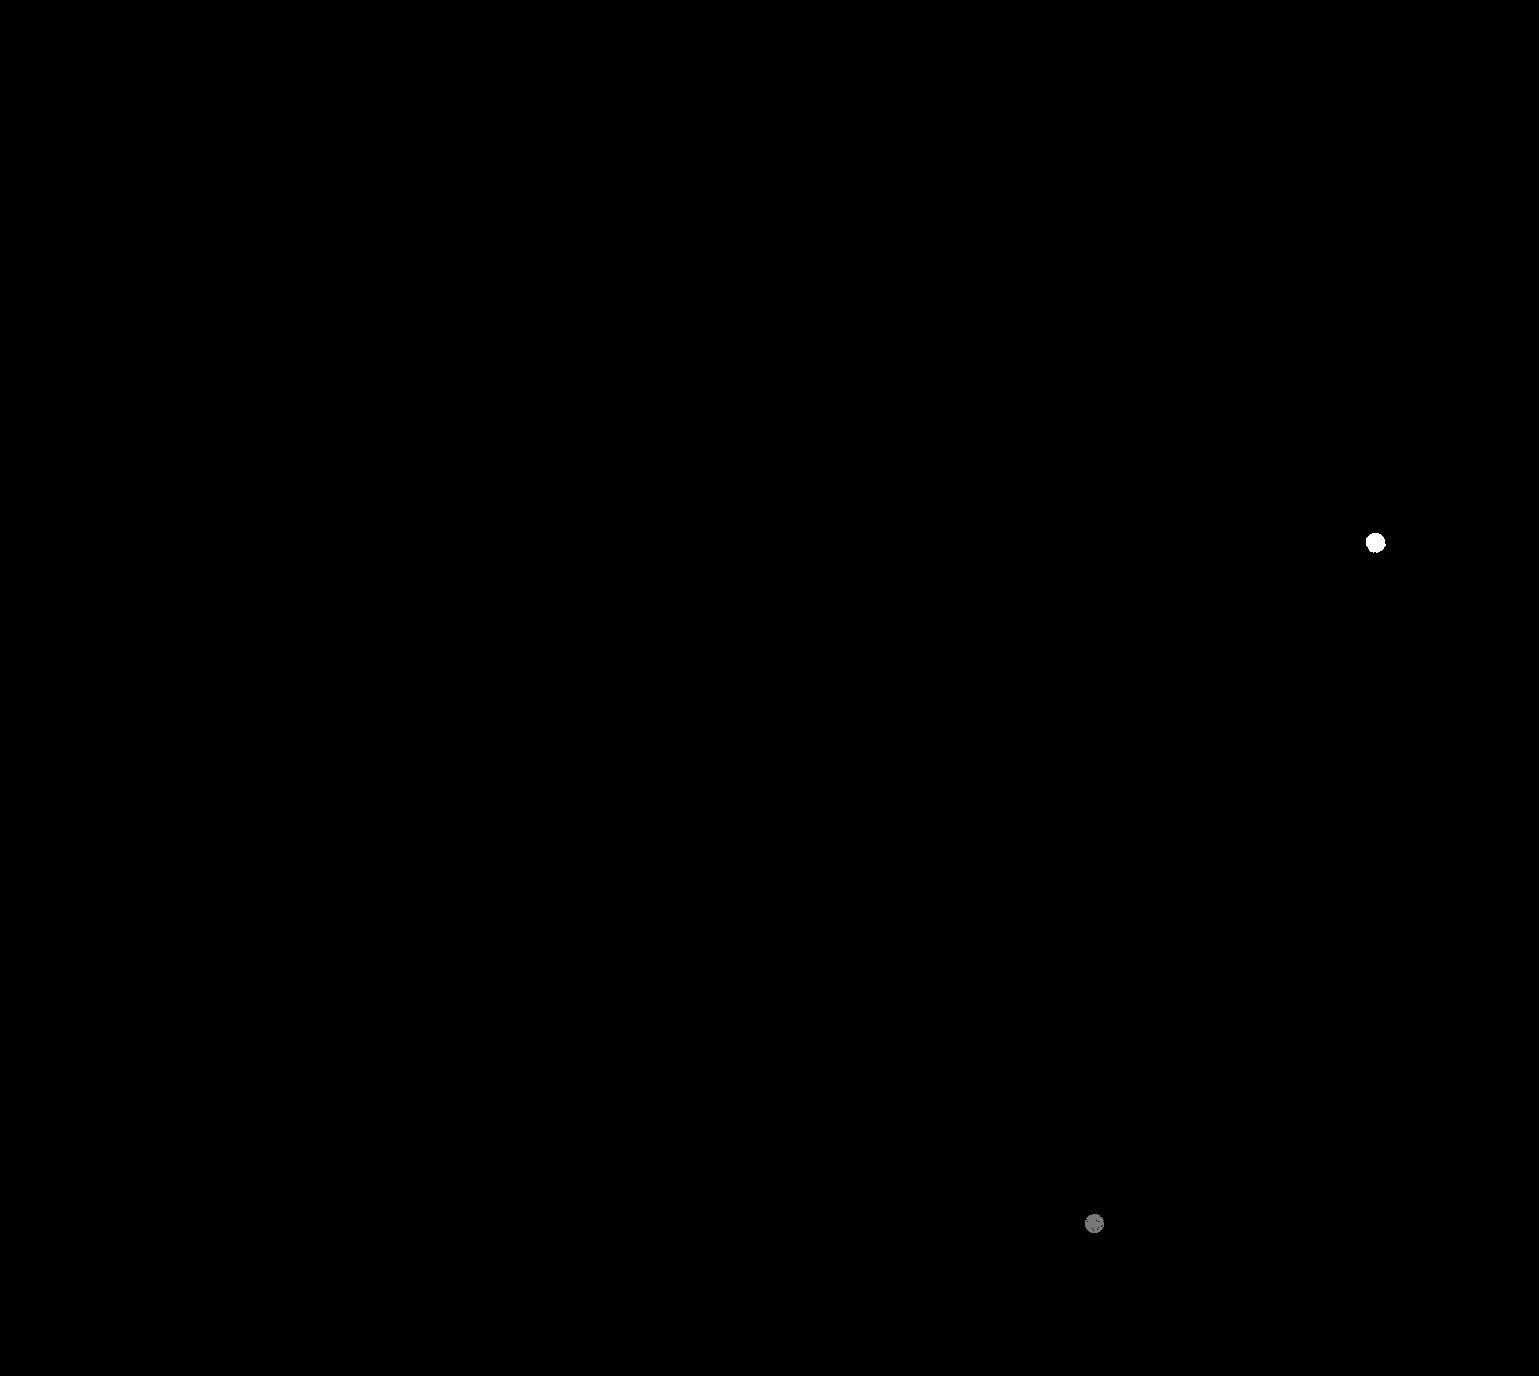

In [13]:
dictt['A03_00Aa']

In [25]:
data_path = "/kaggle/input/multi-Hamamatsu-LG/Total" ## Now importing the normal images themselves

In [26]:
all_data = os.listdir(data_path)
image_names = [image.split(".")[0] for image in  all_data if image.split(".")[-1]=="tiff"]   ## Getting the name of files

In [31]:
class SegmentationDataset(Dataset):
    
    def __init__(self,image_path, images,feature_extractor):
        """_summary_

        Args:
            image_path (string): _Path of the Images_
            images (_type_): _Array of name of images_
            feature_extractor (_type_): _Image feature extractor for Segformer_
        """
        
        self.image_path = image_path
        self.images = images
        self.feature_extractor = feature_extractor
        
        
    def __len__(self):
        """_summary_

        Returns:
            _int_: _length of dataset_
        """
        return len(self.images)        
    
    def __getitem__(self,idx):


        image_name = self.images[idx]
        
        image = Image.open(self.image_path +"/" +image_name +".tiff")  ## Image will be the actual image
        segmentation_mask = dictt[image_name] ## Segmented Image will taken from the dictionary we created

        image = image.convert('RGB')  ## Image will be converted to RGB to reduce size
        
        ## Encoding the data using feature extractor
        encodings = self.feature_extractor(image,segmentation_mask,return_tensors = "pt")
        
        ## Removing the dimension of the batch
        for k,v in encodings.items():
            encodings[k] = v.squeeze_()  
            
        return encodings

In [32]:
from transformers import SegformerFeatureExtractor  ##  Get Feature Extractor


feature_extractor = SegformerFeatureExtractor()

In [33]:
train_dataset = SegmentationDataset(data_path, image_names,feature_extractor)   ## Prepare training dataset

In [34]:
for i in train_dataset:   ## Proving that only 3 possible colors exists. 0 for black, 255 for white. 120 for grey.
    if (len(i['labels'].squeeze().unique()) >2):
        print(i['labels'].squeeze().unique())
        break

tensor([  0, 120, 255])


In [35]:
for k,v in train_dataset[0].items():   ## These are the dimensions of items
    print(v.size())

torch.Size([3, 512, 512])
torch.Size([512, 512])


In [36]:
id2label = {0:0,1:255, 2:120}   ## setting a number to each color
label2id = {0:0,255:1, 120:2}

In [37]:
from transformers import SegformerForSemanticSegmentation  ## Importing the pretrained model
model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(model_name,
                                                         num_labels=3, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.running_mean', 'decode_head.batch_n

Intialising Dataloader

In [38]:
from torch.utils.data import DataLoader ## Getting the dataloader

In [39]:
batch_size = 16  ## Different batch sizes were tried, 16 turned out to be the most efficient with ram

In [40]:
len(image_names)

1200

In [41]:
import random   ## Shuffling image names so model doesn't overfit
random.shuffle(image_names)

In [42]:
train_dataset = SegmentationDataset(data_path,image_names[:1100],feature_extractor) ## Taking 100 Images for training for now
test_dataset =  SegmentationDataset(data_path,image_names[1100:1200],feature_extractor)

In [43]:
len(test_dataset)

100

In [44]:
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True)   ## preparing test dataloader

In [45]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)   ## Preparing train dataloader

In [46]:
len(test_dataloader)

7

Finetuning

In [47]:
from datasets import load_metric   

metric = load_metric("mean_iou")
#metric.compute()

In [49]:
   ## Final path decided
path1 = "/kaggle/working/Hamamatsu_LG_Multi_loss.pt"

In [50]:
import torch   ## Optimizer made.
from torch import nn
#from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm


# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  ## Learning rate
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## GPU used
model.to(device)
print("done")

done


In [ ]:
maxx = 100  ## Max decides because obviously metrics will be lower than this. 
model.train()
for epoch in range(50):  # loop over the dataset multiple times
    metric = load_metric("mean_iou")
    
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].cuda()
        labels = batch["labels"].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()    

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()  ## This is backpropogation
        optimizer.step()   

        # evaluate
        
    with torch.no_grad():   ## No gradient changing
        
        for idx, batch in enumerate(tqdm(test_dataloader)):   ## Testing accuracy
    # get the inputs;
            pixel_values1 = batch["pixel_values"].cuda()
            labels1 = batch["labels"].cuda()
            outputs1 = model(pixel_values=pixel_values1, labels=labels1)
            loss, logits = outputs1.loss, outputs1.logits
            upsampled_logits = nn.functional.interpolate(logits, size=labels1.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels1.detach().cpu().numpy())
        
        # note that the metric expects predictions + labels as numpy arrays

        # let's print loss and metrics every 100 batches
        #predictions=predicted.detach().cpu().numpy()

        #metrics = metric._compute(predictions=predicted.detach().cpu().numpy(), references=labels1.detach().cpu().numpy(),num_labels=len(id2label), 
                               #ignore_index=255,
                               #reduce_labels=False, # we've already reduced the labels before)
                                # )
        metrics = metric.compute(num_labels=len(id2label), ignore_index=255, reduce_labels=False)
        ars = loss.item()  
        print("Loss:", ars)
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

        if maxx < ars:   ## 
            maxx = ars  ## Lowest loss saved
            torch.save(model, path1)